In [236]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
import pandas as pd
import warnings
from typing import List, Tuple
import os
import re

# Suppress pandas warnings
warnings.filterwarnings('ignore')

def get_mask_from_waves(wav_array, wav_min, wav_max):
   return (wav_array >= wav_min) * (wav_array <= wav_max)

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def extract_all_sheets(file_path):
    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names
    
    all_data = [excel_file.parse(sheet_name, header = None) for sheet_name in sheet_names]
    
    return all_data

def get_spreadsheet_coords(df, label):
    """
    Accepts either a single label or a list
    """
    if type(label) is str:
        x_ind, y_ind = np.where(mineral_df == label)
        return x_ind[0], y_ind[0]

    elif type(label) is list:
        x_ind = []
        y_ind = []
        for list_val in label:
            x, y = np.where(mineral_df == list_val)
            x_ind.append(x[0])
            y_ind.append(y[0])
        return np.asarray(x_ind), np.asarray(y_ind)


def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    print(f"Found {len(val_list)}: {val_list}")
    return val_list

from pybaselines import Baseline, utils
from matplotlib import pyplot as plt

class HullRemoval:
    def __init__(self,
                 x_data,
                 y_data,
                invert_data = True,
                do_plots = True):
        self.x_data = x_data
        self.y_data = y_data
        self.baseline_fitter = Baseline(x_data,
                                        check_finite=False)
        # Get the peaks of the current spectrum
        self.peaks = find_peaks(y_data,
                   width = 5)[0]
        # Append the end of the spectrum
        self.peaks = np.append(self.peaks,
                               self.y_data.shape[0]-1)
        self.do_plots = do_plots

    def get_mask_from_waves(self,
                            x_data,
                            wav_min,
                            wav_max):
       return (x_data >= wav_min) * (x_data <= wav_max)

    def interpolate_linear(self,
                           spectrum,
                           indices):
        # Create an interpolation function based on the given indices
        interp_func = interp1d(indices,
                               spectrum[indices],
                               fill_value="extrapolate")
        # Apply the interpolation function to the entire range of indices
        lower_hull = interp_func(np.arange(len(spectrum)))
        return lower_hull
    
    def calculate_baseline(self):

        # Invert the data 
        pix_inverse = 1 / self.y_data 
        
        # Calculate the baseline
        baseline_inv = self.baseline_fitter.snip(pix_inverse,
                                     max_half_window=40,
                                     decreasing=True,
                                     smooth_half_window=0)[0]
        
        # Invert the result
        self.curr_baseline = 1 / baseline_inv

        if self.do_plots:
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.curr_baseline,
                     label='Calculated Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data/self.curr_baseline,
                     label='Hull Quotient')
            plt.legend()

    def calculate_initial_hull(self):
        prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                              self.peaks - self.peaks[0])

        self.concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                      prelim_hull))

        self.initial_quotient = self.y_data/self.concat_hull

        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.concat_hull,
                     label='Hybrid Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     self.initial_quotient,
                     label='Initial Hull Quotient')
            plt.legend()

    def iterate_final_hull(self):
        curr_quotient = self.initial_quotient
        n_gt_one = (curr_quotient > 1.01).sum()
        count = 0
        while n_gt_one > 0:
            curr_index_to_add = curr_quotient.argmax()
            # Append this index to the peaks
            self.peaks = np.unique(np.sort(np.append(self.peaks,
                                                     curr_index_to_add)))
            
            
            prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                             self.peaks - self.peaks[0])
            
            self.final_concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                          prelim_hull))
        
            
            curr_quotient = self.y_data/self.final_concat_hull
            n_gt_one = (curr_quotient > 1).sum()
            count +=1
            if count > 20:
                print('Too many iterations, breaking loop')
                n_gt_one = -1
        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.final_concat_hull,
                     label='Final Iterative Hull')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
            
            plt.figure()
            plt.plot(self.x_data,
                     curr_quotient,
                     label='Final Hull Quotient')
            plt.legend()
        self.final_quotient = curr_quotient

    def make_quotient(self):
        self.calculate_baseline()
        self.calculate_initial_hull()
        self.iterate_final_hull()
        return self.final_quotient

    def return_original_segment(self, wav_min, wav_max):
        curr_mask = self.get_mask_from_waves(self.x_data,
                                             wav_min,
                                             wav_max)
        return self.x_data[curr_mask], self.y_data[curr_mask]


def sum_of_gaussians(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def weighted_sum_EGO_Gaussians(x, *params):
    num_peaks = len(params) // 4
    result = np.zeros_like(x)
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        result += compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
    return result

def find_initial_guess(x, y, peaks):
    initial_guess = []
    for p in peaks:
        initial_guess += [0.5, x[p], 10, -0.1]
    return initial_guess

def calc_sum_EGO_Gaussians_auc_features(x, *params):
    num_peaks = len(params) // 4
    integral_list = []
    crystallinity_list = []
    
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        curr_y_vals = compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
        curr_integral = trapezoid(curr_y_vals, x)
        integral_list.append(curr_integral)
        crystallinity_list.append(si**2 / curr_integral)
    return integral_list, crystallinity_list

def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    # print(f"Found {len(val_list)}: {val_list}")
    return val_list

def parse_mineral_sheet(mineral_df):
    """
    """
    mineral_x, mineral_y = get_spreadsheet_coords(mineral_df, 'Mineral')
    
    # Identify which mineral we're parsing
    curr_mineral = mineral_df.iloc[mineral_x, mineral_y+1]
    print(f"Current mineral: {curr_mineral}")
    
    feature_list = get_val_list(mineral_df,
                                'Feature #')
    
    # Do the same thing for shapes
    region_list = get_val_list(mineral_df,
                                'Region #')
    
    # Note that this matches wrong for sheet 1 right now. 
    # we'll need to double check at a later stage of parsing
    # whether the rows have proper values or not, should be easy
    # using pd.isna
    
    # Do the same thing for shapes
    criteria_list = get_val_list(mineral_df,
                                'Criteria #')
    
    # Do the same thing for final weights
    overall_list = get_val_list(mineral_df,
                                'Overall weighting')

    return feature_list, region_list, criteria_list, overall_list, curr_mineral

def parse_feature_list(feature_list):

    # Retrieve features to include
    fx,fy = get_spreadsheet_coords(mineral_df, feature_list)
    
    feature_subset_df = mineral_df.iloc[fx, :]
    incl_features_df = feature_subset_df[feature_subset_df[1] == 'include']
    excl_features_df = feature_subset_df[feature_subset_df[1] == 'exclude']

    return incl_features_df, excl_features_df, feature_subset_df

def make_feature_dict(curr_incl_features_df):

    # Prepare the output dict
    feature_dict = {}
    
    # Loop the include features
    for incl_feature in range(curr_incl_features_df.shape[0]):
    # incl_feature = 2
        curr_feature = (curr_incl_features_df.iloc[incl_feature, :])
        curr_l_min = curr_feature[2]
        curr_l_max = curr_feature[3]
        
        curr_wav_mask = get_mask_from_waves(wav_array,
                                   curr_l_min,
                                   curr_l_max)
        
        curr_x = wav_array[curr_wav_mask]
        curr_y = curr_pixel[curr_wav_mask]
        
        # Generate the linear regression line
        x_values, y_values = generate_linear_regression(curr_x, curr_y)
        
        # Generate the continuum removed version
        curr_y_hull_ratio = curr_y/y_values
    
        
        # Do the same thing for the reference data
        curr_ref_wav_mask = get_mask_from_waves(curr_ref.Wavelength,
                                   curr_l_min,
                                   curr_l_max)
        
        curr_ref_x = curr_ref.Wavelength[curr_ref_wav_mask]
        curr_ref_y = curr_ref.Reflectance[curr_ref_wav_mask]
        
        
        # Generate the linear regression line
        x_ref_values, y_ref_values = generate_linear_regression(curr_ref_x.values, 
                                                                curr_ref_y.values)
        
        # Generate the continuum removed version
        curr_ref_y_hull_ratio = curr_ref_y/y_ref_values
    
        # Build the dict for the current feature
        curr_feat_dict = {}
        curr_feat_dict['spec_subset_x'] = curr_x
        curr_feat_dict['spec_subset_y'] = curr_y
        curr_feat_dict['spec_regression_x'] = x_values
        curr_feat_dict['spec_reggression_y'] = y_values
        curr_feat_dict['spec_hull_removed'] = curr_y_hull_ratio
        # Add the same features for the reference
        curr_feat_dict['ref_subset_x'] = curr_ref_x
        curr_feat_dict['ref_subset_y'] = curr_ref_y
        curr_feat_dict['ref_regression_x'] = x_ref_values
        curr_feat_dict['ref_reggression_y'] = y_ref_values
        curr_feat_dict['ref_hull_removed'] = curr_ref_y_hull_ratio    
        # Store all of this for the current feature
        this_feat_name = str(incl_feature) + '_' + curr_feature[0]
        feature_dict[this_feat_name] = curr_feat_dict

    return feature_dict

def do_tetracorder_weighting(curr_feat_dict, curr_ref_y_hull_ratio):
    
    for i, feat_name in enumerate(curr_feat_dict):
    # i = 0
    # this_feat = curr_feat_dict[list(curr_feat_dict.keys())[0]]
        this_feat = curr_feat_dict[feat_name]
        # Retrieve the variables we need locally
        spec_hull_ratio = this_feat['spec_hull_removed']
        ref_hull_ratio = this_feat['ref_hull_removed']
        ref_subset_x = this_feat['ref_subset_x']
        curr_ref_y_hull_ratio = this_feat['ref_hull_removed']
        
        # Get the minimum length between the reference and spectrum
        # to interpolate to
        min_length = np.min((len(spec_hull_ratio), len(ref_hull_ratio)))
        
        # Interpolate for regression
        ref_y_hull_ratio_downsampled = np.interp(np.linspace(0, len(curr_ref_y_hull_ratio) - 1, min_length),
                                            np.arange(len(curr_ref_y_hull_ratio)), curr_ref_y_hull_ratio)
        
        # Fit the least squares
        a, b, k, F = perform_least_squares_fit(spec_hull_ratio,
                                               ref_y_hull_ratio_downsampled)
        
        # store F
        this_feat['F'] = F
    
        #TODO this isn't very efficient as noted in tetracorder this should happen before all other calculations so that it doesn't have to happen every spsectrum
        # Store AUC
        this_feat['AUC'] = trapezoid(ref_hull_ratio, ref_subset_x)
    
        # Store depth
        this_feat['ref_depth'] = ref_hull_ratio.min()
        this_feat['spec_depth'] = spec_hull_ratio.min()
    
        # Update the main dict
        curr_feat_dict[list(curr_feat_dict.keys())[i]] = this_feat
    
    # Loop through again and calculate the overall weighting
    area_array = np.empty(len(curr_feat_dict))
    fits_array = np.empty(len(curr_feat_dict))
    depth_array = np.empty(len(curr_feat_dict))
    
    for i, feat_name in enumerate(curr_feat_dict):
        this_feat = curr_feat_dict[feat_name]
        area_array[i] = this_feat['AUC']
        # Extract the Fit variable
        fits_array[i] = this_feat['F']
        # Extract the Depeth variable
        depth_array[i] = this_feat['spec_depth']
    
    
    area_weights = area_array / area_array.sum()
    
    weighted_fits = (fits_array * area_weights).sum()
    weighted_depths = (depth_array * area_weights).sum()
    weighted_fit_x_depth =  (fits_array * depth_array * area_weights).sum()

    return weighted_fits, weighted_depths, weighted_fit_x_depth, area_weights

# At the bandmath stage we're going to need to calculate all available parameters
# Kaolinite crystallinity index	Kx	R 2180/R2166
# Illite spectral maturity	ISM	D(F-2200)/D(F-1900)
# Iron slope	Fe_slope	R1650/R1350
# Aspectral slope	Asp_slope	R1450/R1850
# Albedo	Albedo	Average R1550:1750
# opaque index	Opi	Average R (520:600/1600:1700)
# Fe2+ index	Fe2	(R920+R1650)/(R1020+R1235)

def calc_kx(x_data, y_data):
    # Kaolinite crystallinity index	Kx	R 2180/R2166
    # Get the index of where we are
    ind_2166 = np.searchsorted(x_data, 2166)
    ind_2180 = np.searchsorted(x_data, 2180)
    return y_data[ind_2180] /  y_data[ind_2166]

def calc_fe_slope(x_data, y_data):
    # Iron slope	Fe_slope	R1650/R1350
    # Get the index of where we are
    ind_1650 = np.searchsorted(x_data, 1650)
    ind_1350 = np.searchsorted(x_data, 1350)
    return y_data[ind_1650] /  y_data[ind_1350]

def calc_asp_slope(x_data, y_data):
    # Aspectral slope	Asp_slope	R1450/R1850
    # Get the index of where we are
    ind_1450 = np.searchsorted(x_data, 1450)
    ind_1850 = np.searchsorted(x_data, 1850)
    return y_data[ind_1450] /  y_data[ind_1850]

def calc_arbitrary_ref_ratio(x_data,
                             y_data,
                             ref1_val,
                             ref2_val):
    ind_ref1 = np.searchsorted(x_data, ref1_val)
    ind_ref2 = np.searchsorted(x_data, ref2_val)
    return y_data[ind_ref1] /  y_data[ind_ref2]  

def min_max_normalization(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def cosine_similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def fit_spectrum_range(x_data,
                       y_data,
                       curr_start,
                       curr_stop,
                       n_peak_width = 2,
                       invert_data = True,
                       do_plots = True):

    # Get the mask of the range we're in 
    curr_mask = get_mask_from_waves(x_data,
                                    curr_start,
                                    curr_stop)

    # Get the current x dimension
    curr_wavs = x_data[curr_mask]
    # And the Y depending on data inversion
    if invert_data:
        curr_peaks = 1-y_data[curr_mask]
    else:
        curr_peaks = y_data[curr_mask]

    
    # Try fitting the data with weighted sum of EGOs
    # we need to iterate this in case fitting with many peaks
    # fails and we need to start again
    fitting_success = False
    
    while fitting_success is False:
        # Find initial guess for the parameters
        fit_peaks = find_peaks(curr_peaks,
                               width = n_peak_width)[0]
        initial_guess = find_initial_guess(curr_wavs,
                                           curr_peaks,
                                           fit_peaks)
        try: 
            params, _ = curve_fit(weighted_sum_EGO_Gaussians,
                                  curr_wavs,
                                  curr_peaks,
                                  p0=initial_guess)
            fitting_success = True
        except:
            n_peak_width+=1
            # Don't iterature forever
            if n_peak_width > 20:
                break
            continue
        

    if do_plots and fitting_success:
        plt.figure()
        plt.plot(curr_wavs,
                 curr_peaks,
                 label = 'Original Spectrum')
        plt.plot(curr_wavs[fit_peaks],
                 curr_peaks[fit_peaks],
                 'o',
                 label = 'Identified Peaks')
        plt.legend()

        # Generate x-values for plotting the fitted curve
        x_values = np.linspace(min(curr_wavs),
                               max(curr_wavs),
                               len(curr_wavs))
        
        # Generate y-values for the fitted curve using the obtained parameters
        y_values = weighted_sum_EGO_Gaussians(x_values,
                                              *params)
        
        # Plot the original data and the fitted curve
        # plt.plot(curr_wavs, curr_peaks)
        plt.plot(x_values,
                 y_values, 'r-',
                 label='Fit')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.show()
    if fitting_success:

        correlation_matrix = np.corrcoef(curr_peaks, y_values)
        correlation_xy = correlation_matrix[0,1]
        r_squared = correlation_xy**2

        if r_squared > 0.8:
            return params
        else:
            return []
    else:
        return []


def get_contiguous_intervals(array1: List[int],
                             array2: List[int],
                             bool_list: List[bool],
                             x_array: List[int],
                             min_value: int,
                             max_value: int) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    """
    This function takes two lists that specify intervals, a list of boolean values that specifies whether an operation should be performed on each interval,
    and a min and max value that specifies the global interval. It returns two lists of tuples. Each tuple represents a contiguous interval where the boolean
    value is True or False respectively.

    Args:
    array1 (List[int]): A list of integers representing the start of each interval.
    array2 (List[int]): A list of integers representing the end of each interval.
    bool_list (List[bool]): A list of boolean values specifying whether an operation should be performed on each interval.
    min_value (int): The minimum value of the global interval.
    max_value (int): The maximum value of the global interval.

    Returns:
    Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]: Two lists of tuples. Each tuple represents a contiguous interval where the boolean value is True or False respectively.
    """
    
    # Initialize the lists to hold the True and False ranges.
    true_ranges = []
    false_ranges = []
    
    # Assume hull corrected unless otherwise specified. 
    corrected_range = range(min_value, max_value)
    false_min_list = []
    false_max_list = []
    false_range_list = []
    true_range_list = []
    
    for i, false_val in enumerate(bool_list):
        if false_val is False:
            # Get the min/max areas for not corrected
            curr_min = array1[i]
            curr_max = array2[i]
            
            start_ind = np.searchsorted(x_array, curr_min)
            finish_ind = np.searchsorted(x_array, curr_max)
    
            false_min_list.append(start_ind)
            false_max_list.append(finish_ind)
            
            false_range_list.append(np.arange(start_ind, finish_ind))
    
    # We should be able to do specify the True ranges now from the false ranges
    
    complete_range = np.arange(0, len(x_array))
    excluded_values = np.concatenate(false_range_list)
    
    
    unique_values = np.setdiff1d(complete_range, excluded_values)
    
    # Now we find the continuous segments
    split_points = np.where(np.diff(unique_values) != 1)[0] + 1
    continuous_segments = np.split(unique_values, split_points)
    
    return continuous_segments, false_range_list


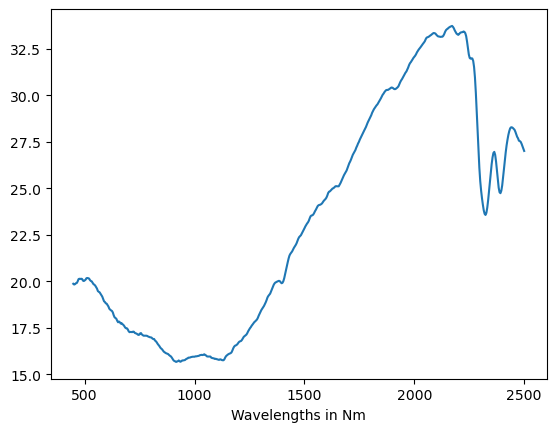

In [10]:
# Let's start by ingesting the criteria we've gotten from Cari
ref_lib_data = extract_all_sheets('Ref Library match criteria v2.xls')

# Input a spectrum 

ref_data = pd.read_csv('reference_lib/Amphibole_03.csv')
wav_array = ref_data.iloc[:,0].values
curr_pixel =  ref_data.iloc[:,1].values

plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelengths in ' + 'Nm')

# Load the master list directly
feature_master_file = 'master_list.xlsx'
feature_master_df = pd.read_excel(feature_master_file)
feature_master_df.dropna(inplace=True)

min_list = feature_master_df['Minima From'].values
max_list = feature_master_df['Minima To'].values
mineral_label = feature_master_df['Applicable Mineral Groups'].tolist()
hull_correct_bool = (feature_master_df['Notes'] == 'hull corrected').tolist()

# l1, l2 = hull_removal.return_original_segment(min_list[0], max_list[0])
# plt.figure()
# plt.plot(l1, l2)

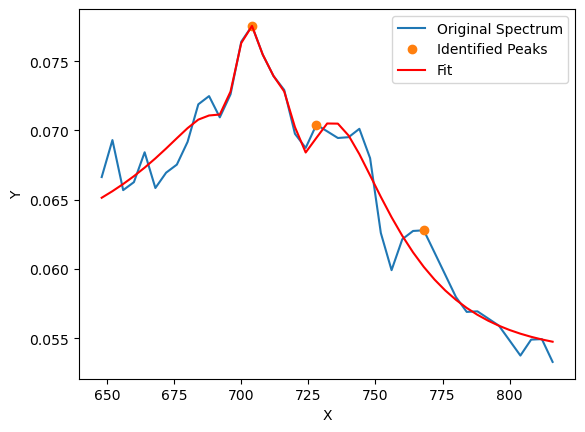

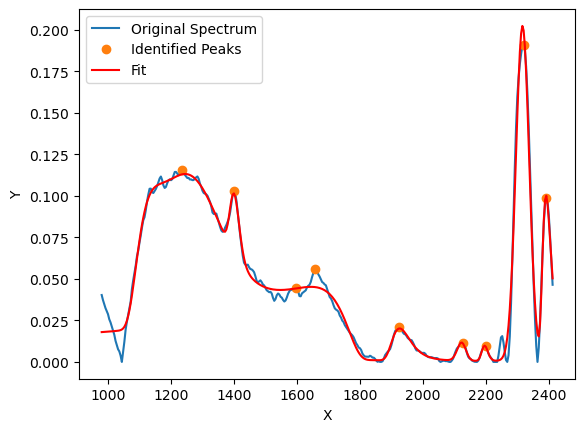

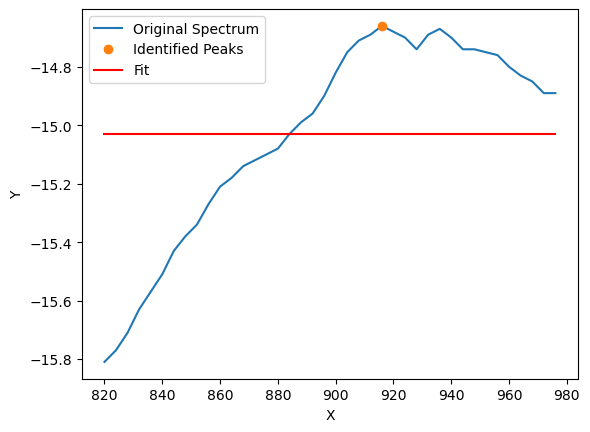

In [50]:
# Remove the hull iteratively 
hull_removal = HullRemoval(wav_array,
                           curr_pixel,
                           do_plots = False)
# Get the hull quotient
curr_quotient = hull_removal.make_quotient()

# Identify the segments that should include a hull correction
# and those that should not
correct_segment_inds, nocorrect_segment_inds = get_contiguous_intervals(min_list,
                                                                         max_list,
                                                                         hull_correct_bool,
                                                                         wav_array,
                                                                         wav_array.min(),
                                                                         wav_array.max())

# Prepare data to be saved in segment-based lists of 
# fit parameters, x axis and y axis segments
# Loop through the corrected segment indices and uncorrected segments
# separately to produce these lists
params_list = []
x_axis_segment_list = []
y_axis_segment_list = []
for this_segment in correct_segment_inds:
    params_list.append(fit_spectrum_range(wav_array[this_segment],
                        curr_quotient[this_segment],
                       curr_start = min_list[hull_correct_bool].min(),
                      curr_stop  = max_list[hull_correct_bool].max()))
    x_axis_segment_list.append(wav_array[this_segment])
    y_axis_segment_list.append(curr_quotient[this_segment])

for i in range(len(nocorrect_segment_inds)):
    
    curr_min = nocorrect_segment_inds[i].min()
    curr_max = nocorrect_segment_inds[i].max()

    params_list.append(fit_spectrum_range(wav_array[nocorrect_segment_inds[i]],
                            curr_pixel[nocorrect_segment_inds[i]],
                           curr_start = min_list[hull_correct_bool].min(),
                          curr_stop  = max_list[hull_correct_bool].max()))
    x_axis_segment_list.append(wav_array[nocorrect_segment_inds[i]])
    y_axis_segment_list.append(curr_pixel[nocorrect_segment_inds[i]])

# Produce a dataframe of the fit and all relevant parameters
# # Create a combined group of parameters
# params = np.concatenate(params_list)
fit_df = pd.DataFrame()
for n_param in range(len(params_list)):
    if len(params_list[n_param]) > 0 :
        n_peaks = int(params_list[n_param].shape[0] / 4)
        
        t1 = pd.DataFrame([params_list[n_param][i*4:((i*4)+4)] for i in range(n_peaks)],
                     columns = ['Amplitude', 'Center', 'Width', 'Asymmetry'])
        
        # Make a nicely filled out dataframe of all our current features 
        temp_df = pd.DataFrame([params_list[n_param][i*4:((i*4)+4)] for i in range(n_peaks)],
                     columns = ['Amplitude', 'Center', 'Width', 'Asymmetry'])
        temp_df['FWHM'] = temp_df.Width * 2.35482
        
        # AUC needs to be calculated with the x axis intact for each segment
        # which means it needs to happen looped across each segment before combining 
        auc_by_peak, crystallinity_by_peak = calc_sum_EGO_Gaussians_auc_features(x_axis_segment_list[n_param],
                                                                                 *params_list[n_param])
        temp_df['Area'] = auc_by_peak
        temp_df['Crystallinity'] = crystallinity_by_peak
        
        fit_df = pd.concat((fit_df, temp_df))

In [295]:
# Get ready to loop the criteria sheets
# Prepare our output dictionary
outputs = {}
# And a place to store simplified results
result_list = []
result_table = pd.DataFrame(columns = ['Overall Match', 'Feature Match', 'Region Match', 'Band Math Match'])

# Produce a loop across each mineral
for mineral_df in ref_lib_data[1:-2]:
# mineral_df = ref_lib_data[18]
    
    # Get the features that we have currently in range
    feature_master_df.dropna(inplace=True)
    
    # Reset the fit_df for the current parameter set
    this_fit_df = fit_df
    
    this_fit_df['FeatureID'] = ''
    this_fit_df['Include/Exclude'] = ''
    this_fit_df['Weight'] = ''
    this_fit_df['WidthMatch'] = ''
    this_fit_df['AmpMatch'] = ''
    this_fit_df['AsymmMatch'] = ''
    
    curr_feat_list, curr_region_list, curr_crit_list, curr_overall_list, curr_mineral_name = parse_mineral_sheet(mineral_df)
    curr_incl_features_df, curr_excl_features_df, feature_subset_df = parse_feature_list(curr_feat_list)
    
    # Handle the reference file loading
    ref_library_directory = 'example_ref_library/'
    # Directory list only of CSV files for the moment
    ref_library_list = [file for file in os.listdir(ref_library_directory) if file[-3:] == 'csv']
    curr_ref_file = [file for file in ref_library_list if re.search(curr_mineral_name, file, re.IGNORECASE)]
    
    # If we matched here we have a reference file
    if len(curr_ref_file) > 0:
        curr_ref_file = curr_ref_file[0]
        curr_ref_df = pd.read_csv(os.path.join(ref_library_directory, curr_ref_file))
        # Make variables to hold our wavelength and reflectance data
        reference_x = curr_ref_df.iloc[:,0].values
        reference_y = curr_ref_df.iloc[:,1].values
        # Do hull removal on the reference data
        hull_removal = HullRemoval(reference_x, reference_y, do_plots=False)
        ref_quotient = hull_removal.make_quotient()
        
    else:
        warnings.warn('No reference match to mineral ' + curr_mineral_name)
        reference_x = []
        reference_y = []
        ref_quotient = []
    
    
    # Reset the column names for these dataframes
    curr_incl_features_df.columns = ['Feature #',	'Include/Exclude',	'L min', 'L max', 'Wmin', 	'Wmax', 	'Hmin%', 	'Hmax%', 	'ASmin', 	'ASmax', 	'Smooth?', 'Weight']
    curr_excl_features_df.columns = ['Feature #',	'Include/Exclude',	'L min', 'L max', 'Wmin', 	'Wmax', 	'Hmin%', 	'Hmax%', 	'ASmin', 	'ASmax', 	'Smooth?', 'Weight']
    feature_subset_df.columns = ['Feature #',	'Include/Exclude',	'L min', 'L max', 'Wmin', 	'Wmax', 	'Hmin%', 	'Hmax%', 	'ASmin', 	'ASmax', 	'Smooth?', 'Weight']
    
    # Iterate the fit df centers for whether we're in range
    # [True for i, curr_center in enumerate(fit_df.Center) if 10000 <= curr_center <= feature_master_df['Minima To'][i]:
    # curr_center = fit_df.Center[0]
    # We need to iterate each of the features and see if they exist in the current fits
    matched_features_list = []
    matched_features_temp_list = []
    for i,k in enumerate(this_fit_df.Center):
        for ii, feature in enumerate(feature_master_df['Product ID']):
            # print(feature_master_df['Minima From'].iloc[ii])
            # feature_master_df['Minima To'].iloc[ii]
            curr_range = (feature_master_df['Minima From'].iloc[ii], feature_master_df['Minima To'].iloc[ii])
            if curr_range[0] <= k <= curr_range[1]:
                # matched_features_list.append(feature)
                this_fit_df['FeatureID'].iloc[i] = feature
                # Identify if this is an include or exclude 
                if feature in curr_incl_features_df['Feature #'].to_list():
                    this_fit_df['Include/Exclude'].iloc[i] = 'Include'
                if feature in curr_excl_features_df['Feature #'].to_list():
                    this_fit_df['Include/Exclude'].iloc[i] = 'Exclude'
                                   
                # Check the other features now that we've identified we're in the right range
                # Dataframe of current feature criteria
                curr_feat_df = feature_subset_df[feature_subset_df['Feature #'] == feature]
    
                # Make sure we only operate on filled out datasets
                if len(curr_feat_df) > 0:
                    # Width
                    curr_width_range = (curr_feat_df['Wmin'].values[0],
                                        curr_feat_df['Wmax'].values[0])
                    if curr_width_range[0] <= this_fit_df['FWHM'].iloc[i] <= curr_width_range[1]:
                        this_fit_df['WidthMatch'].iloc[i] = 'X'
                    
                    # Amplitude
                    # Note that input criteria are in percent (1-100) and we fit
                    # 0-1 range. Here we handle that conversion
                    curr_amp_range = (curr_feat_df['Hmin%'].values[0] / 100,
                                        curr_feat_df['Hmax%'].values[0] / 100)
                    if curr_amp_range[0] <= this_fit_df['Amplitude'].iloc[i] <= curr_amp_range[1]:
                        this_fit_df['AmpMatch'].iloc[i] = 'X'
    
                    # Asymmetry placeholder
                    # We're not really using these yet, lets pretend like they're matches for now
                    # so we can do other math properly 
                    curr_asymm_range = (curr_feat_df['ASmin'].values[0],
                                        curr_feat_df['ASmax'].values[0])
                    # if curr_asymm_range[0] <= fit_df['Amplitude'][i] <= curr_asymm_range[1]:
                    this_fit_df['AsymmMatch'].iloc[i] = 'X'
    
                    # Add the weighting to us
                    this_fit_df['Weight'].iloc[i] = curr_feat_df['Weight'].values[0]
    
    # Bandmath criteria
    
    fx,fy = get_spreadsheet_coords(mineral_df,
                                   curr_crit_list)
    bandmath_subset_df = mineral_df.iloc[fx, :]
    # Clean the dataframe of extra columns - this causes more trouble than it's worth for now
    # bandmath_subset_df.dropna(axis = 1, how = 'all', inplace = True)
    # Update the columns
    bandmath_subset_df.columns = ['Criteria #',	'Feature or R',	'parameter', 'equation',	'Feature or value',	'parameter',	'Weight', 7, 8, 9, 10, 11]
    # Add a result column
    bandmath_subset_df['comparison_result'] = False
    bandmath_subset_df['comparison_value'] = ''
    
    
    # Loop the criteria to parse them out
    for i in range(len(bandmath_subset_df)):
        # This is going to be an ugly parser, we'll rebuild it someday
        # Successfully parses the 1st amphibole feature
        if bandmath_subset_df.iloc[i,:]['Feature or R'] in curr_feat_list:
            if bandmath_subset_df['parameter'].iloc[i, 0] == 'depth':
                # This seems to always mean we've got a set of 2 features to compare, 
                # for now we'll assume that to be so
                # Calculate both features
                feat1 = this_fit_df[this_fit_df.FeatureID == bandmath_subset_df.iloc[i,:]['Feature or R'].strip()]
                feat2 = this_fit_df[this_fit_df.FeatureID == bandmath_subset_df.iloc[i,:]['Feature or value'].strip()]
                # Save both features for diagnostics regardless of what happens later
                bandmath_subset_df['comparison_value'].iloc[i] = [np.round(feat1.Amplitude.values[0], 4),
                                                      np.round(feat2.Amplitude.values[0], 4)]
                # Greater than
                if bandmath_subset_df.iloc[i,:]['equation'] == '>':
                    if feat1.Amplitude.values[0] > feat2.Amplitude.values[0]:
                        bandmath_subset_df['comparison_result'].iloc[i] = True
                # Less than
                if bandmath_subset_df.iloc[i,:]['equation'] == '<':
                    if feat1.Amplitude.values[0] < feat2.Amplitude.values[0]:
                        bandmath_subset_df['comparison_result'].iloc[i] = True
    
        if bandmath_subset_df.iloc[i,:]['Feature or R'] == 'Fe-slope':
            curr_fe_slope = calc_fe_slope(wav_array, curr_pixel)
            bandmath_subset_df['comparison_value'].iloc[i] = curr_fe_slope
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '>':
                if curr_fe_slope > bandmath_subset_df.iloc[i,:]['Feature or value']:
                    bandmath_subset_df['comparison_result'].iloc[i] = True
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '<':
                if curr_fe_slope < bandmath_subset_df.iloc[i,:]['Feature or value']:
                    bandmath_subset_df['comparison_result'].iloc[i] = True
    
        if bandmath_subset_df.iloc[i,:]['Feature or R'] == 'Asp-slope':
            curr_asp_slope = calc_asp_slope(wav_array, curr_pixel)
            bandmath_subset_df['comparison_value'].iloc[i] = curr_asp_slope
            # Greater than
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '>':
                if curr_asp_slope > bandmath_subset_df.iloc[i,:]['Feature or value']:
                    bandmath_subset_df['comparison_result'].iloc[i] = True
            # Less than
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '<':
                if curr_asp_slope < bandmath_subset_df.iloc[i,:]['Feature or value']:
                    bandmath_subset_df['comparison_result'].iloc[i] = True
    
        if len(bandmath_subset_df.iloc[i,:]['Feature or R'].split('/')) > 1:
            curr_comparison_list = bandmath_subset_df.iloc[i,:]['Feature or R'].split('/')
            # Get the value we need to compare at 
            crit0 = curr_comparison_list[0].strip()[1:]
            crit1 = curr_comparison_list[1].strip()[1:]
            
            ref_ratio = calc_arbitrary_ref_ratio(wav_array,
                                                 curr_pixel,
                                                 int(crit0),
                                                 int(crit1))
            bandmath_subset_df['comparison_value'].iloc[i] = ref_ratio
            # Greater than
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '>':
                if ref_ratio > float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                    bandmath_subset_df['comparison_result'].iloc[i] = True
            # Less than
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '<':
                if ref_ratio < float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                    bandmath_subset_df['comparison_result'].iloc[i] = True
    
        # Treat cases where we have a single reflectance comparison set
        if bandmath_subset_df.iloc[i,:]['Feature or R'][0] == 'R' and len(bandmath_subset_df.iloc[i,:]['Feature or R'].split('/')) < 1:
            ref_value = int(bandmath_subset_df.iloc[i,:]['Feature or R'][1:])
            bandmath_subset_df['comparison_value'].iloc[i] = ref_value
    
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '>':
                if ref_value > float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                    bandmath_subset_df['comparison_result'].iloc[i] = True
            if bandmath_subset_df.iloc[i,:]['equation'].strip() == '=<':
                if ref_value < float(bandmath_subset_df.iloc[i,:]['Feature or value']):
                    bandmath_subset_df['comparison_result'].iloc[i] = True
    
    # Region matching
    
    fx,fy = [], []
    fx,fy = get_spreadsheet_coords(mineral_df, curr_region_list)
    region_subset_df = mineral_df.iloc[fx, :]
    region_subset_df.columns = ['Region #',	'L min',	'L max',	'or',	'Feature',	'Smooth?',	'Weight', 8, 9, 10, 11, 12]
    region_subset_df['CosSimilarity'] = ''
    
    if len(reference_x) > 0:
        for i in range(len(region_subset_df)):
        # i = 0 
            curr_min = region_subset_df.iloc[i,:]['L min']
            curr_max = region_subset_df.iloc[i,:]['L max']
            curr_mask = get_mask_from_waves(wav_array, curr_min, curr_max)
            curr_region = curr_quotient[curr_mask]
        
            ref_mask = curr_mask = get_mask_from_waves(reference_x, curr_min, curr_max)
            curr_reference_region = ref_quotient[ref_mask]
            
            curr_region_normalized = min_max_normalization(curr_region)
            curr_reference_region_normalized = min_max_normalization(curr_reference_region)
            
            cos_sim = cosine_similarity(curr_region_normalized, curr_reference_region_normalized)
            
            region_subset_df['CosSimilarity'].iloc[i] = cos_sim
    
        
    # Final weighting needs to be performed for a combined metric
    
    curr_overall_list
    fx,fy = [], []
    fx,fy = get_spreadsheet_coords(mineral_df, curr_overall_list)
    overall_subset_df = mineral_df.iloc[fx, :]
    # overall_subset_df.columns = ['Region #',	'L min',	'L max',	'or',	'Feature',	'Smooth?',	'Weight', 8, 9, 10, 11, 12]
    # This may be too agressive, but we could clean this up to just the weighting values in 2 columns if not
    overall_subset_df.dropna(axis = 1,
                             how = 'all',
                             inplace= True)
    feat_weight = overall_subset_df.iloc[0,1]
    shape_weight = overall_subset_df.iloc[1,1]
    band_weight = overall_subset_df.iloc[1,1]
    
    # Total feature by weight
    weight_total = []
    weight_total = curr_incl_features_df.Weight.sum() + curr_excl_features_df.Weight.sum()
    # Existing include features identified
    incl_features_sum = this_fit_df[this_fit_df['Include/Exclude'] == 'Include'].Weight.sum()
    # How many exclude features do we have? We subtract identified excludes as they shouldn't be there
    excl_features_sum = curr_excl_features_df['Weight'].sum() - this_fit_df[this_fit_df['Include/Exclude'] == 'Exclude'].Weight.sum()
    # Take a sum of include and exclude for this, weighted by our sum of weights
    feature_match_perc = (incl_features_sum + excl_features_sum) / weight_total
    print(f"Identified a feature match of {feature_match_perc * 100} percent to the identified features")
    # display(this_fit_df)
    # display(curr_incl_features_df)
    # display(curr_excl_features_df)
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
    
    # Calculate the weighted match
    # Total feature by weight
    weight_total = []
    
    # Take a sum of include and exclude for this, weighted by our sum of weights
    if len(bandmath_subset_df) > 0:
        bandmath_subset_df.Weight.fillna(1, inplace = True)
        weight_total = bandmath_subset_df.Weight.sum()
        bandmath_match_perc = (bandmath_subset_df.comparison_result * bandmath_subset_df.Weight).sum() / weight_total
        # display(bandmath_subset_df)
        print(f"Identified a band math match of {bandmath_match_perc * 100} percent to the identified features")
        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
    else:
        bandmath_match_perc = 0
    
    # Calculate the weighted match
    # Total feature by weight
    weight_total = []
    weight_total = region_subset_df.Weight.sum()
    
    if len(region_subset_df) > 0 and len(reference_x) > 0 :
        # Take a sum of include and exclude for this, weighted by our sum of weights
        if (region_subset_df.CosSimilarity < 0).sum() > 0:
            print("FOUND COS SIMILARITY OF LESS THAN 0, MATH MAY BE WRONG BELOW")
        region_match_perc = region_subset_df.CosSimilarity.sum() / weight_total
        # display(region_subset_df)
        print(f"Identified a regional shape match of {region_match_perc * 100} percent to the identified features")
        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
        
    # Final weighting
    
    # Fill Na values with 1s for now, ask Cari about what they should be in the future
    overall_subset_df.fillna(1, inplace = True)
    overall_subset_df.columns=['CategoryName', 'Weight']
    overall_subset_df['CategoryValue'] = np.nan
    
    # Add each important category in turn if we have any data for them
    if len(feature_subset_df) > 0:
        overall_subset_df['CategoryValue'].iloc[0] = feature_match_perc
    if len(region_subset_df) > 0:
        overall_subset_df['CategoryValue'].iloc[1] = region_match_perc
    if len(bandmath_subset_df) > 0:
        overall_subset_df['CategoryValue'].iloc[2] = bandmath_match_perc
    
    # Calculate the weighted match
    # Total feature by weight
    # Clean for nans
    overall_subset_df.dropna(inplace = True)
    weight_total = []
    weight_total = overall_subset_df.iloc[:,1].sum()
    
    # Take a sum of include and exclude for this, weighted by our sum of weights
    overall_match_perc = (overall_subset_df['CategoryValue'] * overall_subset_df['Weight']).sum() / overall_subset_df['Weight'].sum()
    print(f"Identified an overall match of {overall_match_perc * 100} percent to the identified features")
    # display(overall_subset_df)
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
    
    curr_min_dict = {}
    curr_min_dict['Features'] = this_fit_df
    curr_min_dict['Shape'] = region_subset_df
    curr_min_dict['Bandmath'] = bandmath_subset_df
    curr_min_dict['Overall'] = overall_subset_df
    curr_min_dict['OverallMatchPercent'] = overall_match_perc
    curr_min_dict['FeatureMatchPercent'] = feature_match_perc
    curr_min_dict['ShapeMatchValue'] = region_match_perc
    curr_min_dict['BandmathMatchPercent'] = bandmath_match_perc
    
    curr_match_list = [curr_mineral_name, overall_match_perc, feature_match_perc, region_match_perc, bandmath_match_perc]
    
    result_list.append(curr_match_list)
    outputs[curr_mineral_name] = curr_min_dict



# Happens after the loop has completed

result_df = pd.DataFrame(result_list, columns = ['Mineral Name', 'Overall Match', 'Feature Match', 'Region Match', 'Bandmath Match'])
result_df.index = result_df['Mineral Name']
result_df.drop(columns = 'Mineral Name', inplace = True)
result_df = result_df.round(3)
display(result_df)

Current mineral: Amphibole
Identified a feature match of 100.0 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Identified a band math match of 100.0 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Identified a regional shape match of 98.85554031980165 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Identified an overall match of 99.71388507995042 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Current mineral: Biotite
Identified a feature match of 75.0 percent to the identified features
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

,Overall Match,Feature Match,Region Match,Bandmath Match
Mineral Name,,,,
Amphibole,0.997,1.000,0.989,1.000
Biotite,0.850,0.750,0.898,1.000
Chlorite,0.584,0.333,0.669,1.000
Dickite,0.493,0.600,0.666,0.000
Epidote,0.369,0.286,0.654,0.333
FLS,0.100,0.200,0.654,0.000
Gypsum,0.222,0.333,0.654,0.000
IronOxide,0.331,0.000,0.324,1.000
Kaolinite,0.575,0.600,0.324,0.500


In [288]:
fit_df.Amplitude

0    0.071060
1    0.019819
2    0.067314
0    0.069678
1    0.036485
2    0.064913
3    0.042841
4    0.019313
5    0.010962
6    0.009166
7    0.201424
8    0.098750
Name: Amplitude, dtype: float64